In [1]:
pip install numpy pandas scikit-learn tensorflow matplotlib seaborn jupyterlab torch torch-geometric rdkit

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 23.2.1 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [2]:
# === Core Libraries ===
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pickle
import glob

# === Progress Bar ===
from tqdm.keras import TqdmCallback

# === Scikit-learn ===
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

# === TensorFlow / Keras ===
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Model
from tensorflow.keras.layers import (
    Input, Embedding, Conv1D, GlobalMaxPooling1D,
    Dense, Concatenate, BatchNormalization, Dropout
)
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.callbacks import Callback, ModelCheckpoint


c:\Users\NongNam\Documents\AI_Builder\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
df = pd.read_csv('Kd.csv')

In [4]:
df.isna().sum()

SMILES             0
target_sequence    0
Kd                 0
dtype: int64

In [5]:
len(df)

55011

In [6]:
# 3. Encode SMILES
smiles_chars = sorted(set(''.join(df['SMILES'])))
char_to_int_smiles = {c: i + 1 for i, c in enumerate(smiles_chars)}

def encode_smiles(smiles):
    return [char_to_int_smiles[c] for c in smiles]

df['smiles_encoded'] = df['SMILES'].apply(encode_smiles)

# 4. Encode protein sequences
aa_list = 'ACDEFGHIKLMNPQRSTVWY'
aa_to_int = {aa: i + 1 for i, aa in enumerate(aa_list)}

def encode_protein(seq):
    return [aa_to_int.get(aa, 0) for aa in seq]

df['protein_encoded'] = df['target_sequence'].apply(encode_protein)

In [7]:
import pandas as pd
from rdkit import Chem
from rdkit.Chem import Descriptors
from Bio.SeqUtils.ProtParam import ProteinAnalysis
import numpy as np

In [8]:
# --- Molecular descriptors from SMILES ---
def compute_molecular_descriptors(smiles):
    mol = Chem.MolFromSmiles(smiles)
    if mol is None:
        return [None] * 5
    return [
        Descriptors.SlogP_VSA5(mol),
        Descriptors.BCUT2D_CHGHI(mol),
        Descriptors.SMR_VSA5(mol),
        Descriptors.MinEStateIndex(mol),
        Descriptors.Chi4v(mol)
    ]

df[['SlogP_VSA5', 'BCUT2D_CHGHI', 'SMR_VSA5', 'MinEStateIndex', 'Chi4v']] = df['SMILES'].apply(
    compute_molecular_descriptors
).apply(pd.Series)

# --- Protein descriptors from sequence ---
def compute_protein_descriptors(seq):
    try:
        analyzed_seq = ProteinAnalysis(seq)
        return [
            analyzed_seq.molecular_weight(),
            analyzed_seq.aromaticity(),
            analyzed_seq.instability_index(),
            analyzed_seq.gravy(),
            analyzed_seq.isoelectric_point()
        ]
    except:
        return [None] * 4
    
df[['Prot_MW', 'Aromaticity', 'Instability', 'Hydropathy', 'IsoelectricPoint']] = df['target_sequence'].apply(
    compute_protein_descriptors
).apply(pd.Series)

[17:55:22] Explicit valence for atom # 22 N, 4, is greater than permitted
[17:55:31] Explicit valence for atom # 22 N, 4, is greater than permitted
[17:55:45] Explicit valence for atom # 22 N, 4, is greater than permitted
[17:56:18] Explicit valence for atom # 22 N, 4, is greater than permitted
[17:57:10] Explicit valence for atom # 22 N, 4, is greater than permitted
[17:57:50] Can't kekulize mol.  Unkekulized atoms: 16 17 18 19 20 21 22 23 25
[17:58:17] Explicit valence for atom # 22 N, 4, is greater than permitted


In [9]:
df = df.dropna(subset=[
    'SlogP_VSA5', 'BCUT2D_CHGHI', 'SMR_VSA5', 'MinEStateIndex', 'Chi4v',
    'Prot_MW', 'Aromaticity', 'Instability', 'Hydropathy','IsoelectricPoint'
])


In [10]:
x_descriptor = df[['SlogP_VSA5', 'BCUT2D_CHGHI', 'SMR_VSA5', 'MinEStateIndex', 'Chi4v']].values
X_protein_descriptor = df[['Prot_MW', 'Aromaticity', 'Instability', 'Hydropathy', 'IsoelectricPoint']].values


In [11]:
from sklearn.preprocessing import StandardScaler

# Fit scalers on training data
mol_scaler = StandardScaler()
prot_scaler = StandardScaler()

x_descriptor_scaled = mol_scaler.fit_transform(x_descriptor)
X_protein_descriptor_scaled = prot_scaler.fit_transform(X_protein_descriptor)


In [12]:
# 5. Pad sequences
max_len_smiles = 100
max_len_protein = 1000

X_smiles = pad_sequences(df['smiles_encoded'], maxlen=max_len_smiles, padding='post')
X_protein = pad_sequences(df['protein_encoded'], maxlen=max_len_protein, padding='post')
y = df['Kd'].values

In [13]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import (
    Input, Embedding, Conv1D, GlobalMaxPooling1D,
    Dense, Dropout, BatchNormalization, Concatenate
)
from tensorflow.keras.losses import MeanSquaredError

# --- Inputs ---
# 1. SMILES token branch
smiles_input = Input(shape=(max_len_smiles,), name='smiles_input')
x1 = Embedding(input_dim=len(char_to_int_smiles) + 1, output_dim=64)(smiles_input)
x1 = Conv1D(128, kernel_size=5, activation='relu', padding='same')(x1)
x1 = BatchNormalization()(x1)
x1 = Conv1D(128, kernel_size=5, activation='relu', padding='same')(x1)
x1 = GlobalMaxPooling1D()(x1)
x1 = Dropout(0.3)(x1)

# 2. Protein token branch
protein_input = Input(shape=(max_len_protein,), name='protein_input')
x2 = Embedding(input_dim=len(aa_to_int) + 1, output_dim=64)(protein_input)
x2 = Conv1D(128, kernel_size=9, activation='relu', padding='same')(x2)
x2 = BatchNormalization()(x2)
x2 = Conv1D(128, kernel_size=9, activation='relu', padding='same')(x2)
x2 = GlobalMaxPooling1D()(x2)
x2 = Dropout(0.3)(x2)

# 3. Molecular descriptors branch (5 features)
mol_desc_input = Input(shape=(5,), name='mol_desc_input')
x3 = Dense(32, activation='relu')(mol_desc_input)
x3 = BatchNormalization()(x3)

# 4. Protein descriptors branch (4 features)
prot_desc_input = Input(shape=(5,), name='prot_desc_input')
x4 = Dense(32, activation='relu')(prot_desc_input)
x4 = BatchNormalization()(x4)

# --- Merge all branches ---
merged = Concatenate()([x1, x2, x3, x4])

# --- Fully connected layers ---
x = Dense(256, activation='relu')(merged)
x = BatchNormalization()(x)
x = Dropout(0.4)(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.3)(x)

# --- Output ---
output = Dense(1, activation='linear', name='kd_output')(x)

# --- Model ---
model = Model(inputs=[smiles_input, protein_input, mol_desc_input, prot_desc_input], outputs=output)
model.compile(optimizer='adam', loss=MeanSquaredError(), metrics=['mae'])

# --- Summary ---
model.summary()


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ smiles_input        │ (None, 100)       │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ protein_input       │ (None, 1000)      │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding           │ (None, 100, 64)   │      2,688 │ smiles_input[0][… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_1         │ (None, 1000, 64)  │      1,344 │ protein_input[0]… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d (Conv1D)     │ (None, 100, 128)  │     41,088 │ embedding[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_2 (Conv1D)   │ (None, 1000, 128) │     73,856 │ embedding_1[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 100, 128)  │        512 │ conv1d[0][0]      │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 1000, 128) │        512 │ conv1d_2[0][0]    │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_1 (Conv1D)   │ (None, 100, 128)  │     82,048 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_3 (Conv1D)   │ (None, 1000, 128) │    147,584 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ mol_desc_input      │ (None, 5)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ prot_desc_input     │ (None, 5)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_max_pooling… │ (None, 128)       │          0 │ conv1d_1[0][0]    │
│ (GlobalMaxPooling1… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_max_pooling… │ (None, 128)       │          0 │ conv1d_3[0][0]    │
│ (GlobalMaxPooling1… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 32)        │        192 │ mol_desc_input[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 32)        │        192 │ prot_desc_input[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 128)       │          0 │ global_max_pooli… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 128)       │          0 │ global_max_pooli… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 32)        │        128 │ dense[0][0]       │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼─────────────────

 Total params: 466,497 (1.78 MB)

 Trainable params: 465,345 (1.78 MB)

 Non-trainable params: 1,152 (4.50 KB)

In [14]:
len(df)

54863

In [15]:
class EpochHistorySaver(Callback):
    def __init__(self, save_dir='SE+CN_MODEL'):
        super().__init__()
        self.save_dir = save_dir
        self.history = {}

    def on_epoch_end(self, epoch, logs=None):
        logs = logs or {}
        for key, value in logs.items():
            self.history.setdefault(key, []).append(value)

        # Save history after each epoch
        filename = f'{self.save_dir}/history_epoch_{epoch+1:02d}.pkl'
        with open(filename, 'wb') as f:
            pickle.dump(self.history, f)


In [16]:
checkpoint_cb = ModelCheckpoint(
    filepath='SE+CN_MODEL/model_epoch_{epoch:02d}.h5',
    save_freq='epoch',
    save_best_only=False,
    save_weights_only=False,
    verbose=1
)

history_cb = EpochHistorySaver(save_dir='SE+CN_MODEL')


In [17]:
history = model.fit(
    [X_smiles, X_protein, x_descriptor_scaled, X_protein_descriptor_scaled],
    y,
    validation_split=0.22,
    epochs=50,
    batch_size=64,
    callbacks=[checkpoint_cb, history_cb]
)

Epoch 1/50
669/669 ━━━━━━━━━━━━━━━━━━━━ 0s 609ms/step - loss: 6.0160 - mae: 1.8490
Epoch 1: saving model to SE+CN_MODEL/model_epoch_01.h5


669/669 ━━━━━━━━━━━━━━━━━━━━ 432s 638ms/step - loss: 6.0126 - mae: 1.8484 - val_loss: 6.6453 - val_mae: 2.1981
Epoch 2/50
669/669 ━━━━━━━━━━━━━━━━━━━━ 0s 605ms/step - loss: 2.3325 - mae: 1.1760
Epoch 2: saving model to SE+CN_MODEL/model_epoch_02.h5


669/669 ━━━━━━━━━━━━━━━━━━━━ 424s 633ms/step - loss: 2.3324 - mae: 1.1760 - val_loss: 3.1720 - val_mae: 1.4053
Epoch 3/50
669/669 ━━━━━━━━━━━━━━━━━━━━ 0s 603ms/step - loss: 1.9615 - mae: 1.0650
Epoch 3: saving model to SE+CN_MODEL/model_epoch_03.h5


669/669 ━━━━━━━━━━━━━━━━━━━━ 423s 632ms/step - loss: 1.9615 - mae: 1.0650 - val_loss: 2.6528 - val_mae: 1.2764
Epoch 4/50
669/669 ━━━━━━━━━━━━━━━━━━━━ 0s 603ms/step - loss: 1.7777 - mae: 1.0111
Epoch 4: saving model to SE+CN_MODEL/model_epoch_04.h5


669/669 ━━━━━━━━━━━━━━━━━━━━ 423s 632ms/step - loss: 1.7777 - mae: 1.0110 - val_loss: 1.2686 - val_mae: 0.8068
Epoch 5/50
669/669 ━━━━━━━━━━━━━━━━━━━━ 0s 602ms/step - loss: 1.6642 - mae: 0.9726
Epoch 5: saving model to SE+CN_MODEL/model_epoch_05.h5


669/669 ━━━━━━━━━━━━━━━━━━━━ 422s 631ms/step - loss: 1.6642 - mae: 0.9726 - val_loss: 2.1790 - val_mae: 1.1219
Epoch 6/50
669/669 ━━━━━━━━━━━━━━━━━━━━ 0s 601ms/step - loss: 1.5835 - mae: 0.9435
Epoch 6: saving model to SE+CN_MODEL/model_epoch_06.h5


669/669 ━━━━━━━━━━━━━━━━━━━━ 421s 629ms/step - loss: 1.5834 - mae: 0.9435 - val_loss: 1.5514 - val_mae: 0.9167
Epoch 7/50
669/669 ━━━━━━━━━━━━━━━━━━━━ 0s 600ms/step - loss: 1.4800 - mae: 0.9090
Epoch 7: saving model to SE+CN_MODEL/model_epoch_07.h5


669/669 ━━━━━━━━━━━━━━━━━━━━ 421s 629ms/step - loss: 1.4800 - mae: 0.9090 - val_loss: 1.3361 - val_mae: 0.8091
Epoch 8/50
669/669 ━━━━━━━━━━━━━━━━━━━━ 0s 603ms/step - loss: 1.4142 - mae: 0.8846
Epoch 8: saving model to SE+CN_MODEL/model_epoch_08.h5


669/669 ━━━━━━━━━━━━━━━━━━━━ 422s 631ms/step - loss: 1.4142 - mae: 0.8846 - val_loss: 1.2561 - val_mae: 0.7616
Epoch 9/50
669/669 ━━━━━━━━━━━━━━━━━━━━ 0s 601ms/step - loss: 1.3712 - mae: 0.8738
Epoch 9: saving model to SE+CN_MODEL/model_epoch_09.h5


669/669 ━━━━━━━━━━━━━━━━━━━━ 421s 629ms/step - loss: 1.3712 - mae: 0.8737 - val_loss: 1.1669 - val_mae: 0.7639
Epoch 10/50
669/669 ━━━━━━━━━━━━━━━━━━━━ 0s 599ms/step - loss: 1.2855 - mae: 0.8450
Epoch 10: saving model to SE+CN_MODEL/model_epoch_10.h5


669/669 ━━━━━━━━━━━━━━━━━━━━ 420s 627ms/step - loss: 1.2855 - mae: 0.8450 - val_loss: 1.0769 - val_mae: 0.7449
Epoch 11/50
669/669 ━━━━━━━━━━━━━━━━━━━━ 0s 598ms/step - loss: 1.2413 - mae: 0.8259
Epoch 11: saving model to SE+CN_MODEL/model_epoch_11.h5


669/669 ━━━━━━━━━━━━━━━━━━━━ 419s 626ms/step - loss: 1.2413 - mae: 0.8259 - val_loss: 1.2419 - val_mae: 0.7777
Epoch 12/50
669/669 ━━━━━━━━━━━━━━━━━━━━ 0s 597ms/step - loss: 1.2153 - mae: 0.8131
Epoch 12: saving model to SE+CN_MODEL/model_epoch_12.h5


669/669 ━━━━━━━━━━━━━━━━━━━━ 419s 626ms/step - loss: 1.2153 - mae: 0.8131 - val_loss: 1.0031 - val_mae: 0.6896
Epoch 13/50
669/669 ━━━━━━━━━━━━━━━━━━━━ 0s 597ms/step - loss: 1.1531 - mae: 0.7901
Epoch 13: saving model to SE+CN_MODEL/model_epoch_13.h5


669/669 ━━━━━━━━━━━━━━━━━━━━ 419s 626ms/step - loss: 1.1531 - mae: 0.7901 - val_loss: 0.9761 - val_mae: 0.6785
Epoch 14/50
669/669 ━━━━━━━━━━━━━━━━━━━━ 0s 598ms/step - loss: 1.1353 - mae: 0.7827
Epoch 14: saving model to SE+CN_MODEL/model_epoch_14.h5


669/669 ━━━━━━━━━━━━━━━━━━━━ 419s 626ms/step - loss: 1.1353 - mae: 0.7827 - val_loss: 1.0074 - val_mae: 0.7078
Epoch 15/50
669/669 ━━━━━━━━━━━━━━━━━━━━ 0s 598ms/step - loss: 1.1053 - mae: 0.7706
Epoch 15: saving model to SE+CN_MODEL/model_epoch_15.h5


669/669 ━━━━━━━━━━━━━━━━━━━━ 419s 626ms/step - loss: 1.1053 - mae: 0.7706 - val_loss: 1.1631 - val_mae: 0.6951
Epoch 16/50
669/669 ━━━━━━━━━━━━━━━━━━━━ 0s 598ms/step - loss: 1.0579 - mae: 0.7520
Epoch 16: saving model to SE+CN_MODEL/model_epoch_16.h5


669/669 ━━━━━━━━━━━━━━━━━━━━ 419s 627ms/step - loss: 1.0579 - mae: 0.7520 - val_loss: 0.9882 - val_mae: 0.6592
Epoch 17/50
669/669 ━━━━━━━━━━━━━━━━━━━━ 0s 598ms/step - loss: 1.0182 - mae: 0.7381
Epoch 17: saving model to SE+CN_MODEL/model_epoch_17.h5


669/669 ━━━━━━━━━━━━━━━━━━━━ 419s 627ms/step - loss: 1.0182 - mae: 0.7381 - val_loss: 1.0704 - val_mae: 0.7683
Epoch 18/50
669/669 ━━━━━━━━━━━━━━━━━━━━ 0s 598ms/step - loss: 0.9882 - mae: 0.7280
Epoch 18: saving model to SE+CN_MODEL/model_epoch_18.h5


669/669 ━━━━━━━━━━━━━━━━━━━━ 418s 625ms/step - loss: 0.9882 - mae: 0.7280 - val_loss: 1.0573 - val_mae: 0.7010
Epoch 19/50
669/669 ━━━━━━━━━━━━━━━━━━━━ 0s 576ms/step - loss: 0.9509 - mae: 0.7144
Epoch 19: saving model to SE+CN_MODEL/model_epoch_19.h5


669/669 ━━━━━━━━━━━━━━━━━━━━ 404s 604ms/step - loss: 0.9510 - mae: 0.7144 - val_loss: 0.8637 - val_mae: 0.6401
Epoch 20/50
669/669 ━━━━━━━━━━━━━━━━━━━━ 0s 582ms/step - loss: 0.9249 - mae: 0.6997
Epoch 20: saving model to SE+CN_MODEL/model_epoch_20.h5


669/669 ━━━━━━━━━━━━━━━━━━━━ 408s 610ms/step - loss: 0.9249 - mae: 0.6997 - val_loss: 0.8413 - val_mae: 0.6270
Epoch 21/50
669/669 ━━━━━━━━━━━━━━━━━━━━ 0s 578ms/step - loss: 0.8839 - mae: 0.6838
Epoch 21: saving model to SE+CN_MODEL/model_epoch_21.h5


669/669 ━━━━━━━━━━━━━━━━━━━━ 405s 605ms/step - loss: 0.8839 - mae: 0.6838 - val_loss: 0.8756 - val_mae: 0.6489
Epoch 22/50
669/669 ━━━━━━━━━━━━━━━━━━━━ 0s 575ms/step - loss: 0.8728 - mae: 0.6767
Epoch 22: saving model to SE+CN_MODEL/model_epoch_22.h5


669/669 ━━━━━━━━━━━━━━━━━━━━ 403s 602ms/step - loss: 0.8729 - mae: 0.6767 - val_loss: 1.0667 - val_mae: 0.6210
Epoch 23/50
669/669 ━━━━━━━━━━━━━━━━━━━━ 0s 576ms/step - loss: 0.9030 - mae: 0.6862
Epoch 23: saving model to SE+CN_MODEL/model_epoch_23.h5


669/669 ━━━━━━━━━━━━━━━━━━━━ 404s 603ms/step - loss: 0.9030 - mae: 0.6862 - val_loss: 0.8524 - val_mae: 0.6300
Epoch 24/50
669/669 ━━━━━━━━━━━━━━━━━━━━ 0s 575ms/step - loss: 0.8457 - mae: 0.6658
Epoch 24: saving model to SE+CN_MODEL/model_epoch_24.h5


669/669 ━━━━━━━━━━━━━━━━━━━━ 403s 602ms/step - loss: 0.8457 - mae: 0.6658 - val_loss: 0.9281 - val_mae: 0.6453
Epoch 25/50
669/669 ━━━━━━━━━━━━━━━━━━━━ 0s 582ms/step - loss: 0.8262 - mae: 0.6621
Epoch 25: saving model to SE+CN_MODEL/model_epoch_25.h5


669/669 ━━━━━━━━━━━━━━━━━━━━ 408s 609ms/step - loss: 0.8262 - mae: 0.6621 - val_loss: 0.8597 - val_mae: 0.6033
Epoch 26/50
669/669 ━━━━━━━━━━━━━━━━━━━━ 0s 583ms/step - loss: 0.8182 - mae: 0.6518
Epoch 26: saving model to SE+CN_MODEL/model_epoch_26.h5


669/669 ━━━━━━━━━━━━━━━━━━━━ 409s 611ms/step - loss: 0.8182 - mae: 0.6518 - val_loss: 0.8326 - val_mae: 0.6046
Epoch 27/50
669/669 ━━━━━━━━━━━━━━━━━━━━ 0s 580ms/step - loss: 0.7928 - mae: 0.6404
Epoch 27: saving model to SE+CN_MODEL/model_epoch_27.h5


669/669 ━━━━━━━━━━━━━━━━━━━━ 406s 607ms/step - loss: 0.7928 - mae: 0.6404 - val_loss: 0.8621 - val_mae: 0.6038
Epoch 28/50
669/669 ━━━━━━━━━━━━━━━━━━━━ 0s 578ms/step - loss: 0.7869 - mae: 0.6375
Epoch 28: saving model to SE+CN_MODEL/model_epoch_28.h5


669/669 ━━━━━━━━━━━━━━━━━━━━ 405s 606ms/step - loss: 0.7869 - mae: 0.6375 - val_loss: 0.8241 - val_mae: 0.5933
Epoch 29/50
669/669 ━━━━━━━━━━━━━━━━━━━━ 0s 580ms/step - loss: 0.7351 - mae: 0.6155
Epoch 29: saving model to SE+CN_MODEL/model_epoch_29.h5


669/669 ━━━━━━━━━━━━━━━━━━━━ 406s 607ms/step - loss: 0.7351 - mae: 0.6155 - val_loss: 0.7800 - val_mae: 0.5976
Epoch 30/50
669/669 ━━━━━━━━━━━━━━━━━━━━ 0s 596ms/step - loss: 0.7528 - mae: 0.6256
Epoch 30: saving model to SE+CN_MODEL/model_epoch_30.h5


669/669 ━━━━━━━━━━━━━━━━━━━━ 417s 624ms/step - loss: 0.7528 - mae: 0.6256 - val_loss: 0.8913 - val_mae: 0.6144
Epoch 31/50
669/669 ━━━━━━━━━━━━━━━━━━━━ 0s 593ms/step - loss: 0.7324 - mae: 0.6170
Epoch 31: saving model to SE+CN_MODEL/model_epoch_31.h5


669/669 ━━━━━━━━━━━━━━━━━━━━ 416s 622ms/step - loss: 0.7324 - mae: 0.6170 - val_loss: 0.8161 - val_mae: 0.5950
Epoch 32/50
669/669 ━━━━━━━━━━━━━━━━━━━━ 0s 596ms/step - loss: 0.7184 - mae: 0.6108
Epoch 32: saving model to SE+CN_MODEL/model_epoch_32.h5


669/669 ━━━━━━━━━━━━━━━━━━━━ 417s 624ms/step - loss: 0.7184 - mae: 0.6108 - val_loss: 0.8403 - val_mae: 0.5832
Epoch 33/50
669/669 ━━━━━━━━━━━━━━━━━━━━ 0s 592ms/step - loss: 0.7023 - mae: 0.6015
Epoch 33: saving model to SE+CN_MODEL/model_epoch_33.h5


669/669 ━━━━━━━━━━━━━━━━━━━━ 415s 620ms/step - loss: 0.7024 - mae: 0.6015 - val_loss: 0.9099 - val_mae: 0.6209
Epoch 34/50
669/669 ━━━━━━━━━━━━━━━━━━━━ 0s 590ms/step - loss: 0.6970 - mae: 0.5996
Epoch 34: saving model to SE+CN_MODEL/model_epoch_34.h5


669/669 ━━━━━━━━━━━━━━━━━━━━ 414s 618ms/step - loss: 0.6970 - mae: 0.5996 - val_loss: 0.8447 - val_mae: 0.6145
Epoch 35/50
669/669 ━━━━━━━━━━━━━━━━━━━━ 0s 590ms/step - loss: 0.6783 - mae: 0.5888
Epoch 35: saving model to SE+CN_MODEL/model_epoch_35.h5


669/669 ━━━━━━━━━━━━━━━━━━━━ 413s 618ms/step - loss: 0.6783 - mae: 0.5888 - val_loss: 0.9637 - val_mae: 0.5781
Epoch 36/50
669/669 ━━━━━━━━━━━━━━━━━━━━ 0s 590ms/step - loss: 0.6754 - mae: 0.5936
Epoch 36: saving model to SE+CN_MODEL/model_epoch_36.h5


669/669 ━━━━━━━━━━━━━━━━━━━━ 413s 617ms/step - loss: 0.6754 - mae: 0.5936 - val_loss: 0.8148 - val_mae: 0.5776
Epoch 37/50
669/669 ━━━━━━━━━━━━━━━━━━━━ 0s 589ms/step - loss: 0.6684 - mae: 0.5846
Epoch 37: saving model to SE+CN_MODEL/model_epoch_37.h5


669/669 ━━━━━━━━━━━━━━━━━━━━ 413s 617ms/step - loss: 0.6685 - mae: 0.5846 - val_loss: 0.7825 - val_mae: 0.5733
Epoch 38/50
669/669 ━━━━━━━━━━━━━━━━━━━━ 0s 591ms/step - loss: 0.6465 - mae: 0.5739
Epoch 38: saving model to SE+CN_MODEL/model_epoch_38.h5


669/669 ━━━━━━━━━━━━━━━━━━━━ 414s 619ms/step - loss: 0.6465 - mae: 0.5740 - val_loss: 0.8466 - val_mae: 0.5709
Epoch 39/50
669/669 ━━━━━━━━━━━━━━━━━━━━ 0s 590ms/step - loss: 0.6461 - mae: 0.5745
Epoch 39: saving model to SE+CN_MODEL/model_epoch_39.h5


669/669 ━━━━━━━━━━━━━━━━━━━━ 414s 618ms/step - loss: 0.6462 - mae: 0.5745 - val_loss: 0.7782 - val_mae: 0.5674
Epoch 40/50
669/669 ━━━━━━━━━━━━━━━━━━━━ 0s 660ms/step - loss: 0.6400 - mae: 0.5694
Epoch 40: saving model to SE+CN_MODEL/model_epoch_40.h5


669/669 ━━━━━━━━━━━━━━━━━━━━ 460s 687ms/step - loss: 0.6401 - mae: 0.5694 - val_loss: 1.2590 - val_mae: 0.5783
Epoch 41/50
669/669 ━━━━━━━━━━━━━━━━━━━━ 0s 627ms/step - loss: 0.6444 - mae: 0.5751
Epoch 41: saving model to SE+CN_MODEL/model_epoch_41.h5


669/669 ━━━━━━━━━━━━━━━━━━━━ 439s 656ms/step - loss: 0.6444 - mae: 0.5751 - val_loss: 0.8604 - val_mae: 0.5731
Epoch 42/50
669/669 ━━━━━━━━━━━━━━━━━━━━ 0s 597ms/step - loss: 0.6413 - mae: 0.5712
Epoch 42: saving model to SE+CN_MODEL/model_epoch_42.h5


669/669 ━━━━━━━━━━━━━━━━━━━━ 419s 626ms/step - loss: 0.6413 - mae: 0.5712 - val_loss: 0.9565 - val_mae: 0.5730
Epoch 43/50
669/669 ━━━━━━━━━━━━━━━━━━━━ 0s 597ms/step - loss: 0.6146 - mae: 0.5618
Epoch 43: saving model to SE+CN_MODEL/model_epoch_43.h5


669/669 ━━━━━━━━━━━━━━━━━━━━ 419s 625ms/step - loss: 0.6147 - mae: 0.5618 - val_loss: 0.8718 - val_mae: 0.5746
Epoch 44/50
669/669 ━━━━━━━━━━━━━━━━━━━━ 0s 603ms/step - loss: 0.6201 - mae: 0.5645
Epoch 44: saving model to SE+CN_MODEL/model_epoch_44.h5


669/669 ━━━━━━━━━━━━━━━━━━━━ 423s 632ms/step - loss: 0.6201 - mae: 0.5645 - val_loss: 0.7415 - val_mae: 0.5503
Epoch 45/50
669/669 ━━━━━━━━━━━━━━━━━━━━ 0s 594ms/step - loss: 0.6017 - mae: 0.5543
Epoch 45: saving model to SE+CN_MODEL/model_epoch_45.h5


669/669 ━━━━━━━━━━━━━━━━━━━━ 417s 623ms/step - loss: 0.6017 - mae: 0.5543 - val_loss: 0.7783 - val_mae: 0.5707
Epoch 46/50
669/669 ━━━━━━━━━━━━━━━━━━━━ 0s 593ms/step - loss: 0.6077 - mae: 0.5540
Epoch 46: saving model to SE+CN_MODEL/model_epoch_46.h5


669/669 ━━━━━━━━━━━━━━━━━━━━ 416s 622ms/step - loss: 0.6077 - mae: 0.5540 - val_loss: 0.8124 - val_mae: 0.5560
Epoch 47/50
669/669 ━━━━━━━━━━━━━━━━━━━━ 0s 580ms/step - loss: 0.5827 - mae: 0.5450
Epoch 47: saving model to SE+CN_MODEL/model_epoch_47.h5


669/669 ━━━━━━━━━━━━━━━━━━━━ 407s 608ms/step - loss: 0.5828 - mae: 0.5450 - val_loss: 0.7310 - val_mae: 0.5529
Epoch 48/50
669/669 ━━━━━━━━━━━━━━━━━━━━ 0s 584ms/step - loss: 0.5903 - mae: 0.5451
Epoch 48: saving model to SE+CN_MODEL/model_epoch_48.h5


669/669 ━━━━━━━━━━━━━━━━━━━━ 410s 612ms/step - loss: 0.5904 - mae: 0.5451 - val_loss: 0.7278 - val_mae: 0.5528
Epoch 49/50
669/669 ━━━━━━━━━━━━━━━━━━━━ 0s 593ms/step - loss: 0.5834 - mae: 0.5446
Epoch 49: saving model to SE+CN_MODEL/model_epoch_49.h5


669/669 ━━━━━━━━━━━━━━━━━━━━ 416s 621ms/step - loss: 0.5834 - mae: 0.5446 - val_loss: 1.1661 - val_mae: 0.5542
Epoch 50/50
669/669 ━━━━━━━━━━━━━━━━━━━━ 0s 595ms/step - loss: 0.5753 - mae: 0.5372
Epoch 50: saving model to SE+CN_MODEL/model_epoch_50.h5


669/669 ━━━━━━━━━━━━━━━━━━━━ 417s 623ms/step - loss: 0.5753 - mae: 0.5372 - val_loss: 1.1335 - val_mae: 0.5632


In [18]:
import joblib

joblib.dump(mol_scaler, 'mol_scaler.save')
joblib.dump(prot_scaler, 'prot_scaler.save')

['prot_scaler.save']

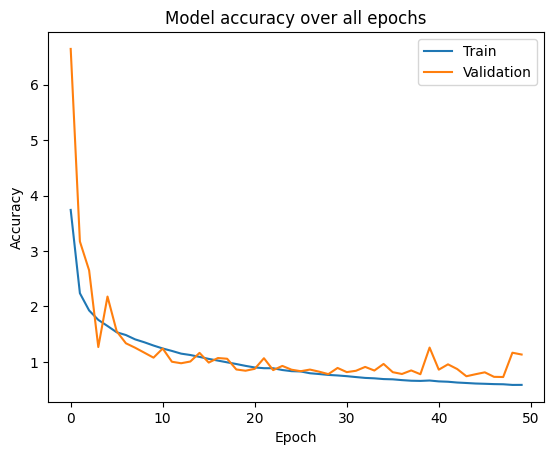

In [19]:
# Load all history files
history_files = sorted(glob.glob('SE+CN_MODEL/history_epoch_*.pkl'))

full_history = {}
for file in history_files:
    with open(file, 'rb') as f:
        epoch_history = pickle.load(f)
    for key, values in epoch_history.items():
        full_history.setdefault(key, []).extend(values[len(full_history.get(key, [])):])

# Plot
import matplotlib.pyplot as plt

plt.plot(full_history['loss'])
plt.plot(full_history['val_loss'])
plt.title('Model accuracy over all epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Validation'])
plt.show()